In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Set plot style for better visuals in the notebook
sns.set(style="whitegrid")
%matplotlib inline

In [7]:
# Load the dataset
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Print columns to double-check
print(df.columns)

Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default'],
      dtype='object')


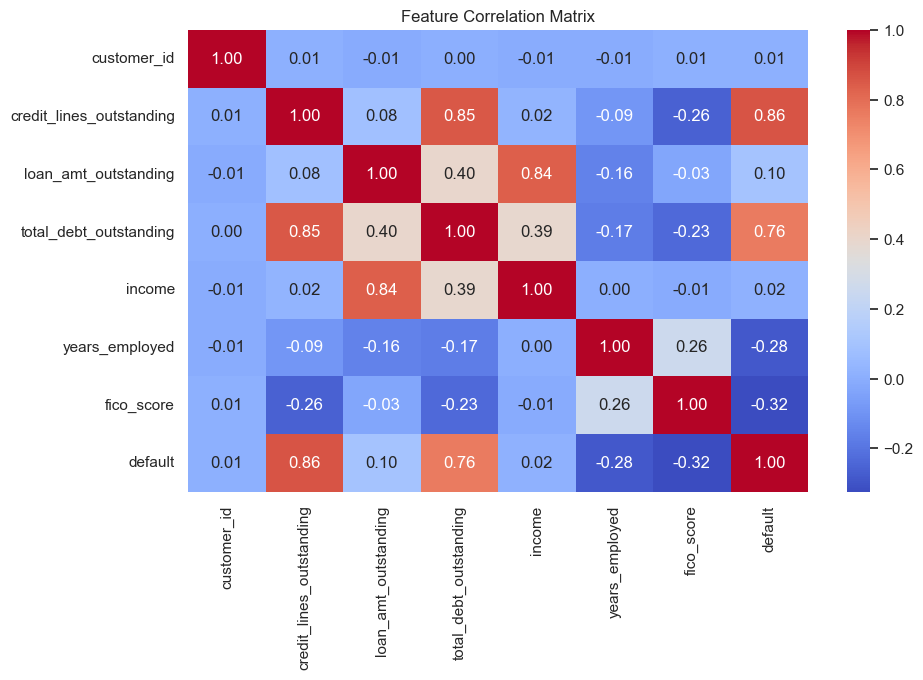

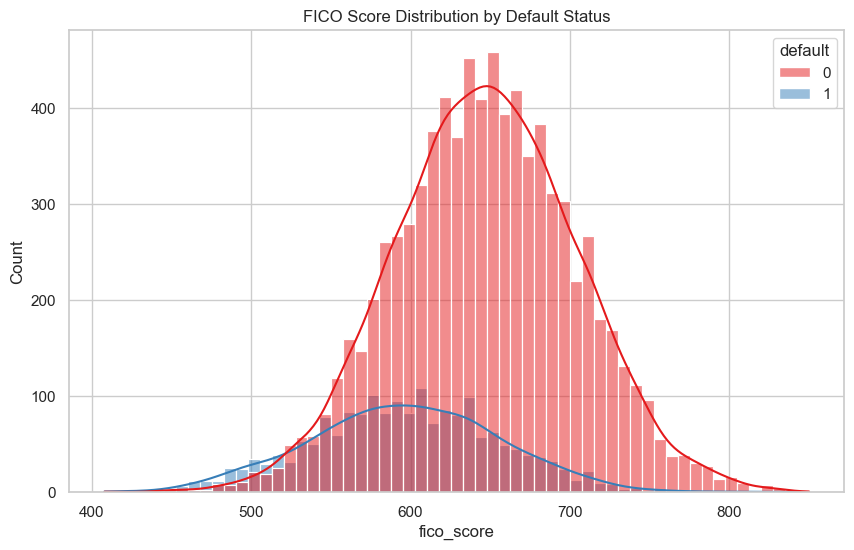

In [8]:
# Create a correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Visualize default rate by FICO score
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='fico_score', hue='default', kde=True, palette='Set1')
plt.title("FICO Score Distribution by Default Status")
plt.show()

In [9]:
# Define features (X) and target (y)
# We exclude 'customer_id' (not a predictor) and 'default' (target)
features = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 
            'income', 'years_employed', 'fico_score']

X = df[features]
y = df['default']

# Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


Model Accuracy: 99.70%


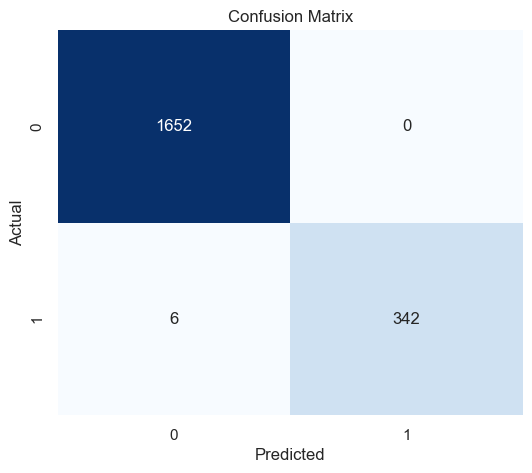


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      0.98      0.99       348

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [10]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of default

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Display Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

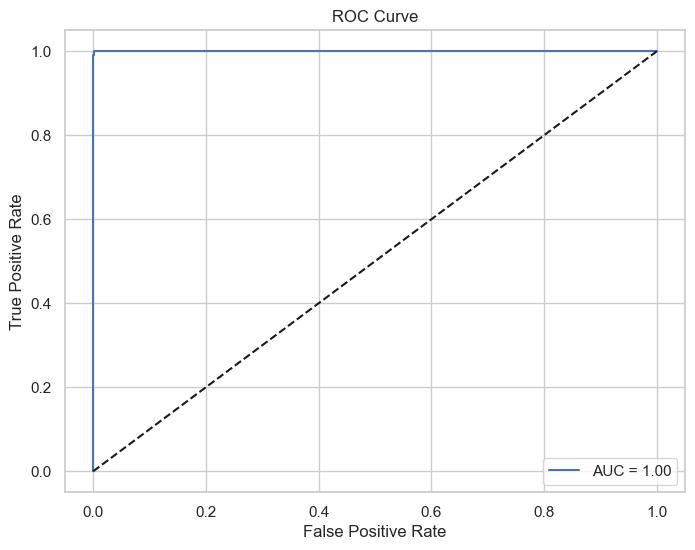

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [12]:
def get_expected_loss(model, loan_features, lgd=1.0):
    """
    Calculates the expected loss for a specific loan.
    
    Args:
    - model: The trained Logistic Regression model.
    - loan_features: A dataframe row or 2D array containing the loan features 
                     (must match the order used in training).
    - lgd: Loss Given Default (default is 1.0, i.e., 100% loss).
    
    Returns:
    - expected_loss: The monetary value of the expected loss.
    """
    # 1. Get the Probability of Default (PD)
    # predict_proba returns [[prob_success, prob_default]]. We want index 1.
    pd = model.predict_proba(loan_features)[0][1]
    
    # 2. Get the Exposure at Default (EAD)
    # We assume 'loan_amt_outstanding' is the 2nd feature in our list:
    # ['credit_lines_outstanding', 'loan_amt_outstanding', ...]
    # If using a DataFrame row, we can access it by name if available, 
    # but for safety here we grab the value from the array.
    ead = loan_features.iloc[0]['loan_amt_outstanding']
    
    # 3. Calculate Result
    return pd * ead * lgd

In [13]:
# 1. Get the Probability of Default (PD) for ALL rows
# This creates a new column with the probability (0.0 to 1.0)
df['default_probability'] = model.predict_proba(df[features])[:, 1]

# 2. Define Loss Given Default (LGD)
lgd = 1.0  # Assumes 100% loss if default occurs

# 3. Calculate Expected Loss (EL)
# EL = PD * EAD * LGD
df['expected_loss'] = df['default_probability'] * df['loan_amt_outstanding'] * lgd

# 4. Display the results
# Let's look at the customers with the highest expected loss
print("Top 5 High-Risk Loans (by Expected Loss):")
print(df[['customer_id', 'loan_amt_outstanding', 'default_probability', 'expected_loss']]
      .sort_values(by='expected_loss', ascending=False)
      .head())

Top 5 High-Risk Loans (by Expected Loss):
      customer_id  loan_amt_outstanding  default_probability  expected_loss
1997      6597386          10210.746690                  1.0   10210.746690
2138      1998635           9563.693515                  1.0    9563.693515
9203      4836461           9105.964213                  1.0    9105.964213
9944      3983392           8989.178801                  1.0    8989.178738
5460      2527305           8841.923630                  1.0    8841.923630


In [14]:
total_exposure = df['loan_amt_outstanding'].sum()
total_expected_loss = df['expected_loss'].sum()

print(f"Total Loan Portfolio Value: ${total_exposure:,.2f}")
print(f"Total Expected Loss:        ${total_expected_loss:,.2f}")
print(f"Portfolio Loss Ratio:       {(total_expected_loss / total_exposure) * 100:.2f}%")

Total Loan Portfolio Value: $41,596,770.34
Total Expected Loss:        $8,229,677.41
Portfolio Loss Ratio:       19.78%
